# DATE 2025 (W07.4)
# Pushing TinyML Forward: End-to-end Near-Memory RISC-V Computing
----

<img src="assets/logo.png" alt="MATCH logo" width="1000"/>

**MATCH** (**M**odel-**A**ware **T**VM-based **C**ompiler for **H**eterogeneous hardware) is a DNN compiler that exploits [Apache TVM](https://tvm.apache.org/)'s BYOC framework, targeting the optimized deployment of DNN applications onto heterogeneous edge System-on-Chip (SoC) platforms.

MATCH is designed to make the process of supporting new targets as simple as possible, thanks to a compilation process guided by _high-level model-based hardware abstractions_. 

The rest of this notebook shows how to extend MATCH to support the deployment of simple DNNs on the _**ARCANE**_ SoC.


## Imports

Set the required paths and import needed classes and functions from MATCH:

In [1]:
import os
import sys
import match
from match.target.target import MatchTarget
from match.target.memory_inst import MemoryInst
from match.transform.requant import MatchRequantRewriter
from match.target.exec_module import ExecModule, ModuleLib
from match.partition.partitioning_pattern import PartitioningPattern
from match.target.exec_module import ComputationalApis
from match.node.node import MatchNode
from match.utils.utils import get_default_inputs
from match.model.model import MatchModel
from tvm.relay.dataflow_pattern import wildcard, is_op, is_constant
from tvm import relay
import onnx

from utils import plot_results
import numpy as np
import matplotlib.pyplot as plt

CURR_PATH = os.getcwd()

## Defining a new target in MATCH

The first step to support a new SoC in MATCH is to define:
- The entire SoC as a subclass of the generic `MatchTarget` class.
- Each accelerator (only one in this case, i.e., Arcane) as a subclass of `ExecModule`.


### Defining an Accelerator (`ExecModule`)

The code below contains the definition of the Arcane class:
- The constructor defines the accelerator name and points to the paths of any required support library that should be compiled together with the generated inference code.
- The `partitioning_patterns` method defines DNN graph patterns that this accelerator supports, each with optional constraints on geometry, data format, etc. In this example, for simplicity, we support `dense` operations with `int32` format, but in general we can match any number of patterns of arbitrary complexity.
- The `comp_apis_def` method defines the APIs of the accelerator (in this case, only the computation APIs, but in general we also support APIs for accelerator setup, data transfer, etc). Essentially, for each pattern supported by the accelerator, it points to backend functions to execute the corresponding operation.
- The `update_constants` method is overridden to modify the default data layout for constant tensors (i.e., weights) of TVM. This is needed because Arcane expects the weights of dense layers to be stored in the CN layout(input channels, output channels) instead of the default (NC).
- The `include_list` method defines extra include paths for compilation.
- If necessary for DSE, you can also override the `zigzag_cost_model` to return an instance of `match.cost_model.zigzag.ZigZagMatchCostModel` as detailed in the documentation.


In [2]:
class Arcane(ExecModule):
    def __init__(self):
        super().__init__(
            name = "arcane",
            libs_required = {
                "arcane_helper": ModuleLib(name="arcane_helper", base_path=CURR_PATH+"/arcane_helper"),
            },
        )
    
    def partitioning_patterns(self):
        def dense_pt():
            """Create pattern for matmul."""
            dense = is_op("nn.dense")(
                wildcard(), is_constant()
            )
            return dense
        def only_int32_dense(node):
            dense = node
            if dense.checked_type.dtype != "int32":
                return False
            return True
        return [
            PartitioningPattern(
                name="DENSE_PT",
                pattern=dense_pt,
                additional_checks=only_int32_dense
            ),
        ]

    def comp_apis_def(self, computational_apis: ComputationalApis=None, pattern_name = "dense"):
        computational_apis.compute_tile = "arcane_compute_wrapper"
        return computational_apis
    
    def update_constants(self, match_node: MatchNode=None, pattern_name: str="dense"):
        for w_tensor in match_node.const_tensors.values():
            if "dense" in w_tensor.name:
                if w_tensor.layout!="CN":
                    w_tensor.data = w_tensor.data.transpose(1,0)
                    w_tensor.dims = [w_tensor.dims[1], w_tensor.dims[0]]
                w_tensor.layout = "CN"
                
    def include_list(self):
        return ["arcane_helper/arcane_helper"]

    # def zigzag_cost_model(self):
    #     return ExampleCostModel

### Defining a Full SoC (`MatchTarget`)

Next, we define the entire SoC, which in this case is based on the [X-Heep](https://github.com/esl-epfl/x-heep) platform, as a `MatchTarget`. In this case, the constructor defines:
- The constructor defines SoC name and the list of its accelerators (`exec_modules`), as well as various paths and function names for compilation.
- The `network_transformations` methods defines a set of custom DNN graph transformation passes to be executed when targeting this SoC. In our case, we use the built-in `MatchRequantRewriter` to replace demanding division operations during requantization with right shifts. Any number of transformations can be defined.
- The `host_memories` method defines the memory hierarchy of the target (visible to TVM), which in this case contains a single-level L2 memory composed of 1024 32-bit words.

In [3]:
ARCANE_L2_MEMORY_SIZE = 8*32*1024

class XHeepSoC(MatchTarget):
    def __init__(self):
        super().__init__(
            exec_modules = [
                Arcane()
            ]
            , name = "xheepsoc",
        )
        self.makefile_path = CURR_PATH+"/arcane_lib/Makefile"
        self.tvm_runtime_include_path = CURR_PATH+"/arcane_lib/tvm_runtime.h"
        self.tvm_runtime_src_path = CURR_PATH+"/arcane_lib/tvm_runtime.c"
        self.init_funcs = ["arcane_helper_init_l1_mem"]
        self.include_list = ["arcane_helper/arcane_helper"]

    def network_transformations(self, opts):
        return [
            ("requant", MatchRequantRewriter()),
        ]

    def host_memories(self):
        return [
            MemoryInst(name="ARCANE_L2_MEM", k_bytes=ARCANE_L2_MEMORY_SIZE),
        ]

## The `arcane_helper` Plugin Library
MATCH's template-based compilation requires each accelerator to provide a backend library of elementary inference operations (usually in C/C++). This library clearly depends on the target, and is typically provided by the HW manufacturers. 


In our simple example, we just need to define two functions:
- To initialize the accelerator
- To perform computation (of a dense layer).
Additional functions can be defined to support more DNN operations.

```c
void arcane_helper_init_l1_mem(){
    l1_hal_init(0, l1_loader, sizeof(l1_loader), 1);
}

void arcane_compute_wrapper(MatchCtx* ctx){
    MatchTensor* tensors = ctx->tensors->tensors;
    int num_tensors = ctx->tensors->num_tensors;
    int out_chs = tensors[num_tensors-1].tiles[1].size;
    int inp_chs = tensors[0].tiles[1].size;
    // reserve matrix in the ARCANE NMC module for the activations
    xmr(m0, tensors[0].base_pt, 1, inp_chs, 1, 1);
    // reserve matrix in the ARCANE NMC module for weights stored in CN format
    xmr(m1, tensors[1].base_pt, inp_chs, out_chs, 1, 1);
    // reserve matrix in the ARCANE NMC module for the outputs
    xmr(m2, tensors[num_tensors-1].base_pt, 1, out_chs, 1, 1);
    // dense op
    carus_mmul_tiling(m2, m0, m1, mNONE, 0, 0);
}
```

## Compiling the DNN

Now that MATCH has been extended to support our SoC, we can compile full DNNs with it. In this example, we use an `int32` ONNX model of a MLP network for MNIST digit recognition. This ONNX can be generated with any ONNX-compilant framework. In our case, we used [PLiNIO](https://github.com/eml-eda/plinio/).

You can view the network's graph by dragging and dropping the `.onnx` file in [Netron](https://netron.app).

To compile it, we define a `MatchModel` as follows, where:
- `default_inputs` is an optional parameter used to add a (properly converted) input to the generated code, for testing purposes.
- `handle_out_fn` is the name of an optional function used to post-process the network output (in our case, determine the predicted class from the DNN scores.

In [4]:
onnx_file_path = CURR_PATH+"/model/mnist.onnx"
input_path = f"{CURR_PATH}/model/input.txt"

mnist_model = MatchModel(
    filename=onnx_file_path,
    model_name="mnist",
    default_inputs=get_default_inputs(
        mod=relay.frontend.from_onnx(onnx.load(onnx_file_path))[0],
        input_files=[input_path],
    ),
    handle_out_fn="mnist_handle_output",
)

### Starting the Compilation

The compilation can be ran with the following code:


In [5]:
match.match(
    model=mnist_model,
    target=XHeepSoC(),
    output_path=CURR_PATH+"/output",
)

2025-04-01 11:55:49,995 - parse_workload_from_path_or_from_module +42 - INFO - Created workload graph with 1 nodes and 0 edges.
2025-04-01 11:55:49,996 - run +29 - INFO - Processing layer 0...
2025-04-01 11:55:49,997 - run +89 - INFO - Launching spatial mapping 1/1: {'D1': ('K', 1), 'D2': ('OY', 1)}.
2025-04-01 11:55:49,998 - run +74 - INFO - Running temporal mapping search engine...


-------------------
[PATTERN MATCHER] Node matched pattern xheepsoc.arcane.DENSE_PT, checking additional conditions
Looking for temporal mapping with following spatial mapping {'DENSE_PT': {'core_allocation': 1, 'spatial_mapping': {'D1': ('K', 1), 'D2': ('OY', 1)}, 'memory_operand_links': {'I': 'I1', 'W': 'I2', 'O': 'O'}, 'unordered_loops': ['FX', 'FY', 'C']}}


 12%|██████████████████▉                                                                                                                                    | 1/8 [00:00<00:00, 940.01it/s]
2025-04-01 11:55:50,004 - run +44 - INFO - Saved CostModelEvaluation(layer=None, core=1) with energy 0.000e+00 and latency 0.000e+00 to tmp/match-layer_None_complete.json
2025-04-01 11:55:50,005 - run +98 - INFO - Saved CostModelEvaluation(layer=None, core=1) with energy 0.000e+00 and latency 0.000e+00 to tmp/match-layer_None_simple.json
2025-04-01 11:55:50,015 - run +146 - INFO - Saved pickled list of 1 CMEs to tmp/match-saved_list_of_cmes.pickle.
2025-04-01 11:55:50,035 - parse_workload_from_path_or_from_module +42 - INFO - Created workload graph with 1 nodes and 0 edges.
2025-04-01 11:55:50,036 - run +29 - INFO - Processing layer 0...
2025-04-01 11:55:50,036 - run +89 - INFO - Launching spatial mapping 1/1: {'D1': ('K', 1), 'D2': ('OY', 1)}.
2025-04-01 11:55:50,037 - run +74 - INFO - Running tempor

[PATTERN MATCHER] Node is supported by xheepsoc.arcane.DENSE_PT with expected latency 0 and expected energy 0
-------------------
[PATTERN MATCHER] Node matched pattern xheepsoc.arcane.DENSE_PT, checking additional conditions
Looking for temporal mapping with following spatial mapping {'DENSE_PT': {'core_allocation': 1, 'spatial_mapping': {'D1': ('K', 1), 'D2': ('OY', 1)}, 'memory_operand_links': {'I': 'I1', 'W': 'I2', 'O': 'O'}, 'unordered_loops': ['FX', 'FY', 'C']}}


 14%|█████████████████████▍                                                                                                                                | 1/7 [00:00<00:00, 1093.41it/s]
2025-04-01 11:55:50,041 - run +44 - INFO - Saved CostModelEvaluation(layer=None, core=1) with energy 0.000e+00 and latency 0.000e+00 to tmp/match-layer_None_complete.json
2025-04-01 11:55:50,042 - run +98 - INFO - Saved CostModelEvaluation(layer=None, core=1) with energy 0.000e+00 and latency 0.000e+00 to tmp/match-layer_None_simple.json
2025-04-01 11:55:50,044 - run +146 - INFO - Saved pickled list of 1 CMEs to tmp/match-saved_list_of_cmes.pickle.
2025-04-01 11:55:50,065 - parse_workload_from_path_or_from_module +42 - INFO - Created workload graph with 1 nodes and 0 edges.
2025-04-01 11:55:50,066 - run +29 - INFO - Processing layer 0...
2025-04-01 11:55:50,067 - run +89 - INFO - Launching spatial mapping 1/1: {'D1': ('K', 1), 'D2': ('OY', 1)}.
2025-04-01 11:55:50,067 - run +74 - INFO - Running tempor

[PATTERN MATCHER] Node is supported by xheepsoc.arcane.DENSE_PT with expected latency 0 and expected energy 0
-------------------
[PATTERN MATCHER] Node matched pattern xheepsoc.arcane.DENSE_PT, checking additional conditions
Looking for temporal mapping with following spatial mapping {'DENSE_PT': {'core_allocation': 1, 'spatial_mapping': {'D1': ('K', 1), 'D2': ('OY', 1)}, 'memory_operand_links': {'I': 'I1', 'W': 'I2', 'O': 'O'}, 'unordered_loops': ['FX', 'FY', 'C']}}


 33%|██████████████████████████████████████████████████▎                                                                                                    | 2/6 [00:00<00:00, 817.76it/s]
2025-04-01 11:55:50,072 - run +44 - INFO - Saved CostModelEvaluation(layer=None, core=1) with energy 0.000e+00 and latency 0.000e+00 to tmp/match-layer_None_complete.json
2025-04-01 11:55:50,073 - run +98 - INFO - Saved CostModelEvaluation(layer=None, core=1) with energy 0.000e+00 and latency 0.000e+00 to tmp/match-layer_None_simple.json
2025-04-01 11:55:50,075 - run +146 - INFO - Saved pickled list of 1 CMEs to tmp/match-saved_list_of_cmes.pickle.


[PATTERN MATCHER] Node is supported by xheepsoc.arcane.DENSE_PT with expected latency 0 and expected energy 0


2025-04-01 11:55:50,189 - select_implementation +256 - INFO - Using injective.cpu for multiply based on highest priority (10)
2025-04-01 11:55:50,194 - select_implementation +256 - INFO - Using injective.cpu for add based on highest priority (10)
2025-04-01 11:55:50,198 - select_implementation +256 - INFO - Using injective.cpu for right_shift based on highest priority (10)
2025-04-01 11:55:50,203 - select_implementation +256 - INFO - Using injective.cpu for clip based on highest priority (10)
2025-04-01 11:55:50,209 - select_implementation +256 - INFO - Using injective.cpu for multiply based on highest priority (10)
2025-04-01 11:55:50,214 - select_implementation +256 - INFO - Using injective.cpu for add based on highest priority (10)
2025-04-01 11:55:50,219 - select_implementation +256 - INFO - Using injective.cpu for right_shift based on highest priority (10)
2025-04-01 11:55:50,224 - select_implementation +256 - INFO - Using injective.cpu for clip based on highest priority (10)
2025

[TEMPLATE WRITER] Generating node main_2
[TEMPLATE WRITER] Generating node main_1
[TEMPLATE WRITER] Generating node main_0


{'mnist': <match.relay.compiled_module.CompiledModuleResult at 0xffff54bba9e0>}

##  Generated Code

The generated code is split over multiple files. 
- `./output/src/main.c` is the entry point, which essentially calls:
    * The runtime function that runs the inference (`match_mnist_runtime`).
    * The custom output handler function to interpret the results (`match_handle_output`).

The runtime function (defined in `./output/src/mnist/runtime.c`), in turn, calls functions define in the `codegen` folder, which contains the most interesting part of the DNN-generated code:

In [6]:
!ls output/codegen/mnist/src/

mnist_lib0.c  mnist_lib1.c  mnist_lib2.c  mnist_lib3.c	mnist_lib4.c


The first two files in this folder (`_lib0.c` and `_lib1.c`) contain TVM-generated functions, including constant allocations, lowered code for unsupported operations, and the main inference function. The remaining files (`_lib2.c` etc) contain BYOC-generated code. In our case, this corresponds to the functions implementing the matched dense layers.

#### TVM-Generated Code

In [7]:
!tail -n 18 output/codegen/mnist/src/mnist_lib1.c

#ifdef __cplusplus
extern "C"
#endif
TVM_DLL int32_t tvmgen_mnist___tvm_main__(int32_t* match_inp_0_buffer_var, int32_t* output_buffer_var, uint8_t* global_const_workspace_0_var, uint8_t* global_workspace_1_var) {
  void* sid_1_let = (&(global_workspace_1_var[512]));
  void* sid_2_let = (&(global_workspace_1_var[0]));
  void* sid_3_let = (&(global_workspace_1_var[512]));
  void* sid_4_let = (&(global_workspace_1_var[0]));
  void* sid_5_let = (&(global_workspace_1_var[256]));
  if (tvmgen_mnist_match_main_0(match_inp_0_buffer_var, sid_1_let) != 0 ) return -1;
  if (tvmgen_mnist_fused_multiply_add_right_shift_clip(sid_1_let, sid_2_let, global_const_workspace_0_var, global_workspace_1_var) != 0 ) return -1;
  if (tvmgen_mnist_match_main_1(sid_2_let, sid_3_let) != 0 ) return -1;
  if (tvmgen_mnist_fused_multiply_add_right_shift_clip_1(sid_3_let, sid_4_let, global_const_workspace_0_var, global_workspace_1_var) != 0 ) return -1;
  if (tvmgen_mnist_match_main_2(sid_4_let, sid_5_let) != 0 ) re

#### MATCH-generated Code

In [8]:
!cat output/codegen/mnist/src/mnist_lib2.c

/*
 * Mohamed Amine Hamdi <mohamed.hamdi@polito.it>
 *
 * Copyright (C) 2024 Politecnico Di Torino
 * 
 * Licensed under the Apache License, Version 2.0 (the "License");
 * you may not use this file except in compliance with the License.
 * You may obtain a copy of the License at
 *
 *     http://www.apache.org/licenses/LICENSE-2.0
 *
 * Unless required by applicable law or agreed to in writing, software
 * distributed under the License is distributed on an "AS IS" BASIS,
 * WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
 * See the License for the specific language governing permissions and
 * limitations under the License. 
*/
// include params file
#include <nodes/mnist/main_0_params.h>
#ifdef __MATCH_TEST_NODE_WITH_HELPER__
#include <xheepsoc/node_helper_nn.h>
#endif

int __attribute__ ((noinline)) tvmgen_mnist_match_main_0(
    void* var_input_0_pt,
    void* out_dense_out_pt
)
{
    MatchCtx* ctx = main_0_ctx;


    main_0_input_0->base_pt = var_input_0_p

## Host-only Compilation

MATCH allows you to easily disable code generation for accelerators, thus generating a host-only version of the code, which can be useful to measure acceleration.

In [9]:
arcane_cpu_only = XHeepSoC()
arcane_cpu_only.disable_exec_module("arcane")
match.match(
    model=mnist_model,
    target=arcane_cpu_only,
    output_path=CURR_PATH+"/output_cpu",
)

2025-04-01 11:55:51,260 - select_implementation +256 - INFO - Using injective.cpu for squeeze based on highest priority (10)
2025-04-01 11:55:51,297 - select_implementation +256 - INFO - Using injective.cpu for expand_dims based on highest priority (10)
2025-04-01 11:55:51,339 - select_implementation +256 - INFO - Using injective.cpu for multiply based on highest priority (10)
2025-04-01 11:55:51,366 - select_implementation +256 - INFO - Using injective.cpu for squeeze based on highest priority (10)
2025-04-01 11:55:51,395 - select_implementation +256 - INFO - Using injective.cpu for expand_dims based on highest priority (10)
2025-04-01 11:55:51,426 - select_implementation +256 - INFO - Using injective.cpu for multiply based on highest priority (10)
2025-04-01 11:55:51,490 - select_implementation +253 - WARNING - One or more operators have not been tuned. Please tune your model for better performance. Use DEBUG logging level to see more details.
2025-04-01 11:55:51,490 - select_impleme

{'mnist': <match.relay.compiled_module.CompiledModuleResult at 0xffff532c1390>}

In this case, the codegen folder only contains TVM files, which also include lowered versions of dense layers:

In [10]:
!ls ./output_cpu/codegen/mnist/src/

mnist_lib0.c  mnist_lib1.c


In [11]:
!cat ./output_cpu/codegen/mnist/src/mnist_lib1.c

// tvm target: c -keys=riscv_cpu,cpu -device=riscv_cpu
#define TVM_EXPORTS
#include "tvm/runtime/c_runtime_api.h"
#include "tvm/runtime/c_backend_api.h"
#include <math.h>
#include <stdbool.h>
#ifdef __cplusplus
extern "C"
#endif
TVM_DLL int32_t tvmgen_mnist_fused_nn_contrib_dense_pack_add(int32_t* p0, int32_t* T_add, uint8_t* global_const_workspace_6_var, uint8_t* global_workspace_7_var);
#ifdef __cplusplus
extern "C"
#endif
TVM_DLL int32_t tvmgen_mnist_fused_nn_contrib_dense_pack_add_right_shift_clip(int32_t* p0, int32_t* compute, uint8_t* global_const_workspace_2_var, uint8_t* global_workspace_3_var);
#ifdef __cplusplus
extern "C"
#endif
TVM_DLL int32_t tvmgen_mnist_fused_nn_contrib_dense_pack_add_right_shift_clip_1(int32_t* p0, int32_t* compute, uint8_t* global_const_workspace_4_var, uint8_t* global_workspace_5_var);
#ifdef __cplusplus
extern "C"
#endif
TVM_DLL int32_t tvmgen_mnist___tvm_main__(int32_t* match_inp_0_buffer_var, int32_t* output_buffer_var, uint8_t* global_const_worksp

## Analyzing Relay IR

We can also compare the TVM Relay IR graphs generated with/without support for the Arcane accelerator.

In the first case, we offload dense operations to ARCANE exploiting MATCH:

In [12]:
!cat output/models/mnist/relay/mnist.relay

def @main(%match_inp_0: Tensor[(1, 784), int32] /* ty=Tensor[(1, 784), int32] */) -> Tensor[(1, 10), int32] {
  %0 = @tvmgen_mnist_match_main_0(%match_inp_0) /* ty=Tensor[(1, 128), int32] */;
  %1 = multiply(%0, meta[relay.Constant][0] /* ty=Tensor[(1, 128), int32] span=/fc1/Constant:0:0 */) /* ty=Tensor[(1, 128), int32] span=/fc1/Mul:0:0 */;
  %2 = add(%1, meta[relay.Constant][1] /* ty=Tensor[(1, 128), int32] span=/fc1/Constant_1:0:0 */) /* ty=Tensor[(1, 128), int32] span=/fc1/Add:0:0 */;
  %3 = right_shift(%2, 15 /* ty=int32 */) /* ty=Tensor[(1, 128), int32] */;
  %4 = clip(%3, a_min=0f, a_max=255f) /* ty=Tensor[(1, 128), int32] span=/fc1/Clip:0:0 */;
  %5 = @tvmgen_mnist_match_main_1(%4) /* ty=Tensor[(1, 64), int32] */;
  %6 = multiply(%5, meta[relay.Constant][2] /* ty=Tensor[(1, 64), int32] span=/fc2/Constant:0:0 */) /* ty=Tensor[(1, 64), int32] span=/fc2/Mul:0:0 */;
  %7 = add(%6, meta[relay.Constant][3] /* ty=Tensor[(1, 64), int32] span=/fc2/Constant_1:0:0 */) /* ty=Tensor[(1, 64

While in the CPU-only version everything is handled by the host:

In [13]:
!cat output_cpu/models/mnist/relay/mnist.relay

def @main(%match_inp_0: Tensor[(1, 784), int32] /* ty=Tensor[(1, 784), int32] */) -> Tensor[(1, 10), int32] {
  %0 = nn.dense(%match_inp_0, meta[relay.Constant][0] /* ty=Tensor[(128, 784), int32] span=/fc1/MatMul:0:0 */, units=None, out_dtype="int32") /* ty=Tensor[(1, 128), int32] span=/fc1/MatMul:0:0 */;
  %1 = multiply(%0, meta[relay.Constant][1] /* ty=Tensor[(1, 128), int32] span=/fc1/Constant:0:0 */) /* ty=Tensor[(1, 128), int32] span=/fc1/Mul:0:0 */;
  %2 = add(%1, meta[relay.Constant][2] /* ty=Tensor[(1, 128), int32] span=/fc1/Constant_1:0:0 */) /* ty=Tensor[(1, 128), int32] span=/fc1/Add:0:0 */;
  %3 = right_shift(%2, 15 /* ty=int32 */) /* ty=Tensor[(1, 128), int32] */;
  %4 = clip(%3, a_min=0f, a_max=255f) /* ty=Tensor[(1, 128), int32] span=/fc1/Clip:0:0 */;
  %5 = nn.dense(%4, meta[relay.Constant][3] /* ty=Tensor[(64, 128), int32] span=/fc2/MatMul:0:0 */, units=None, out_dtype="int32") /* ty=Tensor[(1, 64), int32] span=/fc2/MatMul:0:0 */;
  %6 = multiply(%5, meta[relay.Constan

If you are interested, the `models/mnist/relay` folder contains the evolution of the graph throughout the compilation. For instance, we can see that in the final one (`mnist.relay`)e `right_shift` operations are used instead of divisions.

## Testing on the Hardware

To generate the final binary for the target, you need to go into the `output` (or `output_cpu`) folders, from a Docker terminal and compile the generated C code. This step requires a target-specific C compilation environment, and will be skipped for sake of brevity.

Let's flash a pre-compiled the board and see if the model works correclty. For reference, the sample input we compiled together with the network is the following:

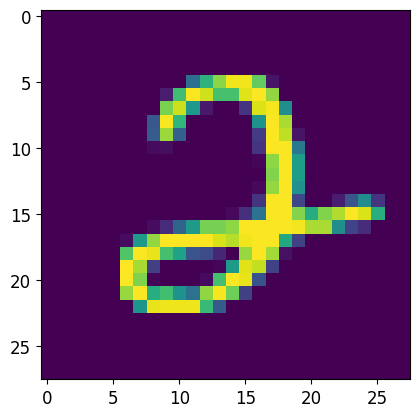

In [14]:
x = np.loadtxt(input_path).reshape([28, 28])
plt.imshow(x)

## Acceleration Results

We profiled the accelerated and the host-only code and we obtained the following results:

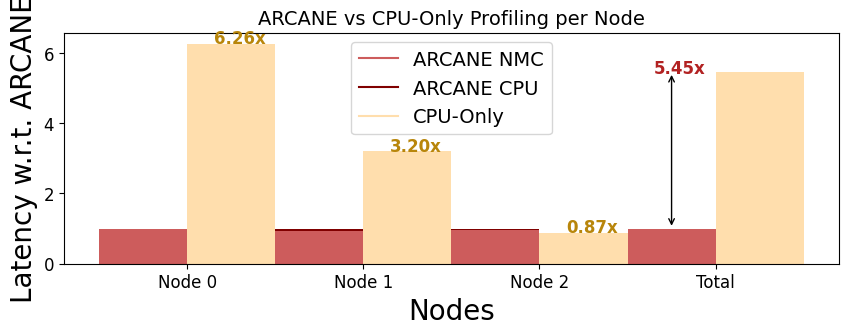

In [15]:
plot_results()